<a href="https://colab.research.google.com/github/ccarranz/Series-temporales/blob/main/df-guardia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Carga de Librerías


import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

"""Carga de datos"""
# Mount data from drive
from google.colab import drive
import os
import requests
drive.mount('/content/drive')
import pandas as pd

#Conexión
df_guardia = pd.read_excel("/content/drive/My Drive/guardia.xlsx")
df_laboratorio = pd.read_excel("/content/drive/My Drive/laboratorio.xlsx")
df_laboratorio = df_laboratorio.drop(['Atenciones', 'Pacientes'], axis=1)
df_internaciones = pd.read_excel("/content/drive/My Drive/internaciones.xlsx")

#crea copias para uso en caso de diferenciar
#En la carga del dataset ya asignamos a la primer columna como index
df_guardia.set_index('Fecha', inplace=True)
df_guardia.index.freq = 'D'
df_laboratorio.set_index('Fecha', inplace=True)
df_laboratorio.index.freq = 'D'
df_internaciones.set_index('Fecha', inplace=True)
df_internaciones.index.freq = 'D'

df_guardia=df_guardia['2022-01-01':]
df_laboratorio=df_laboratorio['2022-01-01':]
df_internaciones=df_internaciones['2022-01-01':]

df_guardia.head()
df_laboratorio.head()
df_internaciones.head()


Mounted at /content/drive


,Ingresos
Fecha,
2022-01-01,5
2022-01-02,4
2022-01-03,28
2022-01-04,22
2022-01-05,25


In [2]:
#Summary de las series
summary_guardia = df_guardia.describe()
summary_lab = df_laboratorio.describe()
summary_int = df_internaciones.describe()
print(summary_guardia)
print(summary_lab)
print(summary_int)

#df_guardia.head()
#df_laboratorio.head()
#df_internaciones.head()
#df_preprocesado = df_preprocesado.reset_index()
#df_preprocesado = df_preprocesado.drop(columns=['datetime'])
#df_preprocesado

       Atenciones
count  664.000000
mean   450.882530
std     83.977452
min    212.000000
25%    394.000000
50%    448.500000
75%    510.250000
max    677.000000
       Prestaciones
count    661.000000
mean    5145.207262
std     2055.041348
min      574.000000
25%     4820.000000
50%     5849.000000
75%     6488.000000
max     8835.000000
         Ingresos
count  661.000000
mean    24.181543
std     10.774986
min      2.000000
25%     16.000000
50%     26.000000
75%     32.000000
max     47.000000


In [3]:
print('Cantidad de NaNs:')
for column in df_guardia:
    nans = df_guardia[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna Atenciones: 0


In [4]:
df_time_diffs = df_guardia.index.to_series().diff().dt.total_seconds() #total_seconds es una función de pandas que retorna la duración total de cada elemento expresada en segundos.
print(df_time_diffs.value_counts())

86400.0    663
Name: Fecha, dtype: int64


In [8]:
df_guardia['Atenciones']

Fecha
2022-01-01    258
2022-01-02    313
2022-01-03    526
2022-01-04    508
2022-01-05    497
             ... 
2023-10-22    379
2023-10-23    579
2023-10-24    515
2023-10-25    537
2023-10-26    472
Freq: D, Name: Atenciones, Length: 664, dtype: int64

In [10]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [11]:
tr, vl, ts = train_val_test_split(df_guardia['Atenciones'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (531,)
Tamaño set de validación: (66,)
Tamaño set de prueba: (67,)


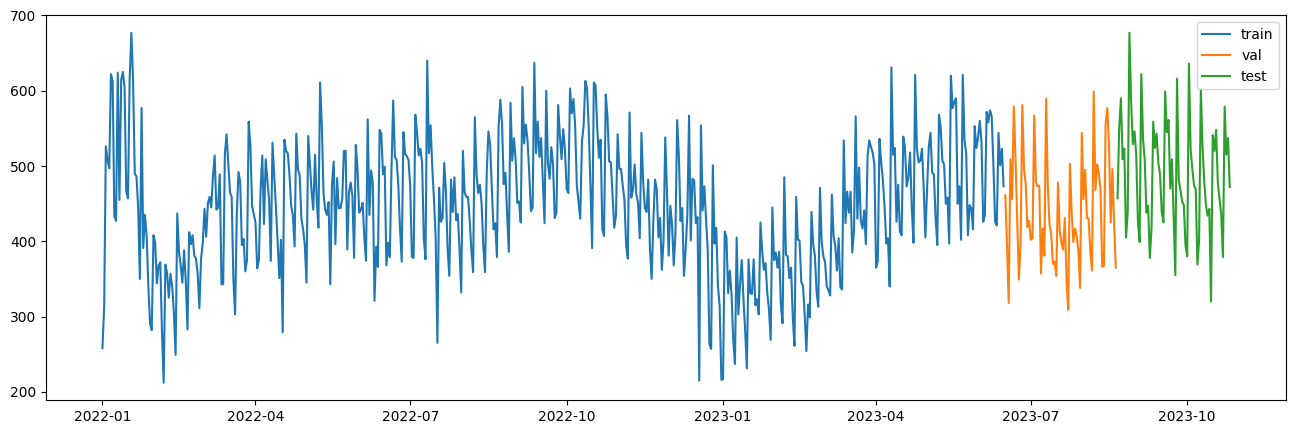

In [12]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr,label="train")
ax.plot(vl,label="val")
ax.plot(ts,label="test")
plt.legend();

In [13]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos (utilizando ventanas deslizantes de longitud input_length)
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [14]:
tr.values

array([258, 313, 526, 508, 497, 622, 613, 433, 427, 624, 455, 614, 625,
       604, 466, 457, 616, 677, 614, 490, 486, 445, 350, 577, 391, 435,
       407, 339, 290, 282, 408, 398, 344, 368, 372, 280, 212, 369, 358,
       325, 357, 340, 305, 249, 437, 386, 368, 345, 388, 347, 283, 412,
       396, 408, 381, 377, 357, 311, 377, 398, 443, 406, 450, 459, 445,
       487, 514, 442, 445, 489, 343, 343, 516, 542, 503, 465, 459, 350,
       303, 436, 492, 479, 395, 403, 360, 375, 559, 528, 447, 436, 425,
       364, 375, 469, 514, 423, 509, 481, 455, 374, 531, 489, 446, 401,
       351, 402, 279, 535, 520, 517, 488, 447, 434, 393, 543, 495, 488,
       430, 416, 395, 345, 540, 502, 466, 442, 515, 456, 418, 611, 556,
       464, 442, 435, 452, 343, 476, 506, 396, 484, 444, 444, 456, 520,
       520, 389, 465, 478, 460, 378, 528, 496, 438, 442, 451, 406, 374,
       562, 435, 494, 477, 321, 393, 366, 548, 543, 489, 499, 368, 398,
       379, 497, 587, 512, 508, 475, 417, 373, 545, 516, 513, 50

In [15]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 24 dias consecutivos a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 1 a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [16]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (506, 24, 1), y_tr: (506, 1, 1)
Set de validación - x_vl: (41, 24, 1), y_vl: (41, 1, 1)
Set de prueba - x_ts: (42, 24, 1), y_ts: (42, 1, 1)


In [17]:
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [18]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [19]:
data_s, scaler = escalar_dataset(data_in)

In [20]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [21]:
#Verificamos...
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento:  212/309/320
Min x_tr/x_vl/x_ts con escalamiento:  -1.0/-0.5827956989247312/-0.5354838709677419
Min y_tr/y_vl/y_ts sin escalamiento:  212/309/320
Min y_tr/y_vl/y_ts con escalamiento:  -1.0/-0.5467289719626167/-0.49532710280373826
Max x_tr/x_vl/x_ts sin escalamiento:  677/599/677
Max x_tr/x_vl/x_ts con escalamiento:  1.0/0.8084112149532707/0.9999999999999998
Max y_tr/y_vl/y_ts sin escalamiento:  640/599/636
Max y_tr/y_vl/y_ts con escalamiento:  1.0/0.8084112149532707/0.981308411214953


Creación y entrenamiento de la Red LSTM


In [22]:
tf.random.set_seed(123) #para garantizar la reproducibidad del entrenamiento

In [24]:
#tf.config.experimental.enable_op_determinism() #realizaremos el entrenamiento usando la GPU proporcionada por Google Colab

In [25]:
N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar

In [26]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) #cada uno de los datos de entrada será un arreglo de tamaño 24 (240 minutos de entrada) x 1 (feature).

In [27]:
modelo = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

Compilacion del modelo

In [28]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [29]:
optimizador = RMSprop(learning_rate=5e-5)

In [30]:
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

Entrenamiento del modelo

In [31]:
EPOCHS = 80 #iteraciones de entrenamiento
BATCH_SIZE = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración)

In [32]:
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2 #vemos como evoluciona el entrenamiento
)

Epoch 1/80
2/2 - 5s - loss: 0.3943 - val_loss: 0.3345 - 5s/epoch - 3s/step
Epoch 2/80
2/2 - 0s - loss: 0.3897 - val_loss: 0.3339 - 225ms/epoch - 112ms/step
Epoch 3/80
2/2 - 0s - loss: 0.3869 - val_loss: 0.3333 - 228ms/epoch - 114ms/step
Epoch 4/80
2/2 - 0s - loss: 0.3840 - val_loss: 0.3329 - 244ms/epoch - 122ms/step
Epoch 5/80
2/2 - 0s - loss: 0.3818 - val_loss: 0.3325 - 217ms/epoch - 108ms/step
Epoch 6/80
2/2 - 0s - loss: 0.3798 - val_loss: 0.3321 - 212ms/epoch - 106ms/step
Epoch 7/80
2/2 - 0s - loss: 0.3776 - val_loss: 0.3318 - 233ms/epoch - 117ms/step
Epoch 8/80
2/2 - 0s - loss: 0.3754 - val_loss: 0.3315 - 231ms/epoch - 116ms/step
Epoch 9/80
2/2 - 0s - loss: 0.3736 - val_loss: 0.3312 - 231ms/epoch - 115ms/step
Epoch 10/80
2/2 - 0s - loss: 0.3719 - val_loss: 0.3309 - 219ms/epoch - 110ms/step
Epoch 11/80
2/2 - 0s - loss: 0.3699 - val_loss: 0.3307 - 221ms/epoch - 111ms/step
Epoch 12/80
2/2 - 0s - loss: 0.3683 - val_loss: 0.3304 - 234ms/epoch - 117ms/step
Epoch 13/80
2/2 - 0s - loss: 0.

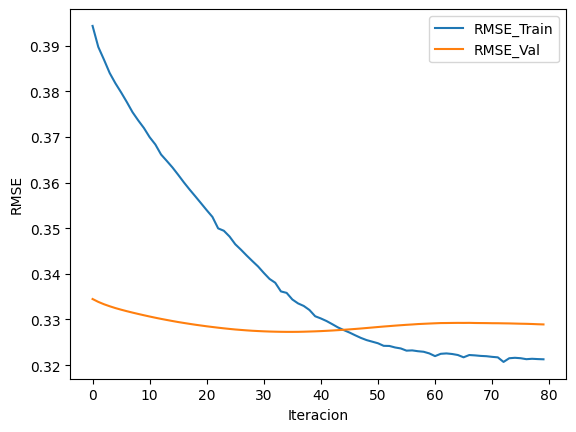

In [33]:
plt.plot(historia.history['loss'],label='RMSE_Train')
plt.plot(historia.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.legend();

Desempeño del modelo

In [35]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

In [36]:
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.318
  RMSE val:	 0.329
  RMSE test:	 0.346


Predicciones (forecasting) con el modelo entrenado

In [37]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [38]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

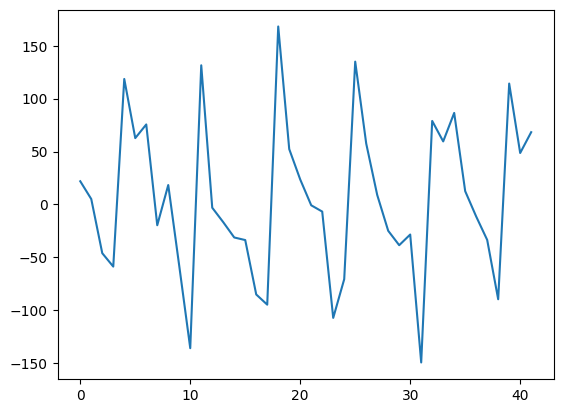

In [39]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

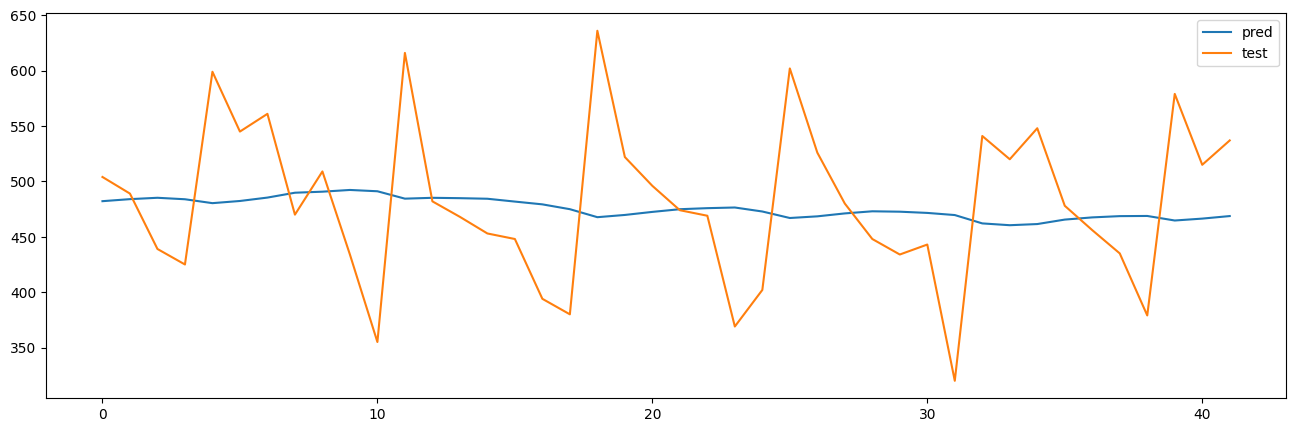

In [41]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();